In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os 
import cv2
import numpy as np
import tensorflow
import keras 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, optimizers, Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, GlobalMaxPool2D,GlobalAveragePooling2D
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model

2024-03-25 18:20:08.304423: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-25 18:20:08.304548: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-25 18:20:08.444507: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
from PIL import Image
sample_image_path = "/kaggle/input/deeplearning/augmented/all_data/sad/image0000027.jpg"

with Image.open(sample_image_path) as img:
    image_width, image_height = img.size

print("Image Width:", image_width)
print("Image Height:", image_height)


Image Width: 48
Image Height: 48


In [5]:
os.listdir('/kaggle/input/deeplearning/augmented/all_data')

['fearful', 'angry', 'neutral', 'sad', 'surprised', 'happy']

In [6]:
INPUT_PATH = "/kaggle/input/deeplearning/augmented/all_data/"
total_images = 0
for dir in os.listdir(INPUT_PATH):
    count = len(os.listdir(INPUT_PATH + dir))
    total_images += count
    print(f"{dir} has {count} images")

print(f"total_images : {total_images}")

fearful has 5138 images
angry has 4957 images
neutral has 6269 images
sad has 6113 images
surprised has 4071 images
happy has 9042 images
total_images : 35590


In [7]:
all_emotions= ['fearful', 'angry', 'neutral', 'sad', 'surprised', 'happy']

e=0
i=0
img_label=[]
img_arr=[]
label_to_text = {}

for dir_ in os.listdir(INPUT_PATH):
    if dir_ in all_emotions:
        label_to_text[e] = dir_
        for f in os.listdir(INPUT_PATH + dir_ + "/"):
            img_arr.append( np.array(cv2.imread(INPUT_PATH + dir_ + "/" + f)))
            img_label.append(e)
            i+=1
        print(f"loaded all {dir_} images to numpy arrays")  
        e+=1
        
img_arr,img_label = np.array(img_arr),np.array(img_label)
print(img_arr.shape,img_label.shape)

img_label = to_categorical(img_label)
img_label.shape

loaded all fearful images to numpy arrays
loaded all angry images to numpy arrays
loaded all neutral images to numpy arrays
loaded all sad images to numpy arrays
loaded all surprised images to numpy arrays
loaded all happy images to numpy arrays
(35590, 48, 48, 3) (35590,)


(35590, 6)

In [8]:
img_arr = img_arr / 255.

X_train, X_test, y_train, y_test = train_test_split(img_arr, img_label,
                                                    shuffle=True, stratify=img_label,
                                                    test_size=0.2, random_state=69)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                    shuffle=True, stratify=y_train,
                                                    test_size=0.2, random_state=69)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((22777, 48, 48, 3),
 (5695, 48, 48, 3),
 (7118, 48, 48, 3),
 (22777, 6),
 (5695, 6),
 (7118, 6))

In [9]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [10]:
from tensorflow.keras.applications import MobileNetV2

#creating base model
base_model= MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_width, img_height, img_depth)))

#freezing the layers in the pretrained model
for layer in base_model.layers:
    layer.trainable= True
    
model= Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(6, activation='softmax')
])

#compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

#display the model summary
model.summary()

/tmp/ipykernel_34/1096269440.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model= MobileNetV2(weights='imagenet', include_top=False, input_tensor=Input(shape=(img_width, img_height, img_depth)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [11]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00008,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    min_delta=0.0001,
    factor=0.25,
    patience=4,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [12]:
batch_size = 128
epochs = 50

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])


history= model.fit(X_train, y_train, epochs= epochs, steps_per_epoch=1500, validation_data= (X_val, y_val), callbacks= callbacks)

In [14]:
model.save("/kaggle/working/my_model01.keras")

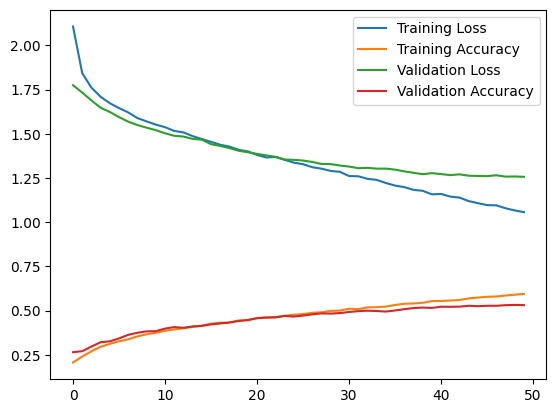

In [56]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [21]:
def preprocess_data(INPUT_PATH):
    all_emotions = ['fearful', 'angry', 'neutral', 'sad', 'surprised', 'happy']
    e = 0
    i = 0
    img_label = []
    img_arr = []
    label_to_text = {}

    for dir_ in os.listdir(INPUT_PATH):
        if dir_ in all_emotions:
            label_to_text[e] = dir_
            for f in os.listdir(os.path.join(INPUT_PATH, dir_)):
                img_arr.append(np.array(cv2.imread(os.path.join(INPUT_PATH, dir_, f))))
                img_label.append(e)
                i += 1
            print(f"loaded all {dir_} images to numpy arrays")
            e += 1

    img_arr, img_label = np.array(img_arr), np.array(img_label)
    print(img_arr.shape, img_label.shape)

    img_label = to_categorical(img_label)
    return img_arr, img_label

In [62]:
from tensorflow.keras.preprocessing import image
uploaded_image_path = '/kaggle/input/deeplearning/augmented/all_data/surprised/ffhq_102.png'
img = image.load_img(uploaded_image_path, target_size=(48, 48))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0 

# Make predictions
predictions = model.predict(img_array)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[[0.65452147 0.18500248 0.00293264 0.13382539 0.01528883 0.00842914]]


In [82]:
import requests
from PIL import Image
from tensorflow.keras.preprocessing import image
import numpy as np
from io import BytesIO

uploaded_image_path = 'https://as1.ftcdn.net/v2/jpg/00/78/45/12/1000_F_78451230_H8DNUDCQ0Tx5PvkAOYV4VxJgBDoGFlRM.jpg'

def resize_image(url, size=(48, 48)):
    try:
        # Download the image
        response = requests.get(url)
        image_data = BytesIO(response.content)
        img = Image.open(image_data)

        # Resize the image
        resized_img = img.resize(size)

        return resized_img
    except Exception as e:
        print(f"Error resizing image: {e}")
        return None
    
resized_img = resize_image(uploaded_image_path)

# Convert resized image to array
img_array = image.img_to_array(resized_img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0 

# Now, you can use your trained model to make predictions
# Example assuming you have a model already defined
# predictions = model.predict(img_array)
# print(predictions)

Npredictions = model.predict(img_array)
print(Npredictions)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[[0.23256606 0.03790475 0.19808798 0.43556064 0.07795294 0.0179276 ]]


Predicted class: 3


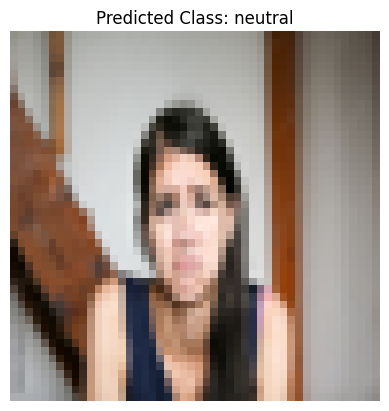

In [83]:
class_names = ['angry', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
predicted_class = np.argmax(Npredictions)

# Print the predicted class label
print("Predicted class:", predicted_class)

predicted_class_index = np.argmax(Npredictions)
predicted_class_name = class_names[predicted_class_index]
plt.imshow(resized_img)
plt.axis('off')
plt.title(f'Predicted Class: {predicted_class_name}')
plt.show()

In [53]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,621,952 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,970,196 (57.11 MB)

 Trainable params: 4,978,694 (18.99 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 9,957,390 (37.98 MB)